In [ ]:
import pandas as pd  # needs openpyxl
import torch
import torch.utils.data as data_utils


## Nanostring data: gene expression values and metadata

In [ ]:
file_path = "./NanoString/NanoString 360_TRPTINF_0235.xlsx"
with pd.ExcelFile(file_path) as xlsx:
    sample_ids = pd.read_excel(xlsx, sheet_name="genes", usecols="B").applymap(
        lambda x: x[0:3]
    )

    expressions = pd.read_excel(xlsx, sheet_name="genes", usecols="C:ABX").set_index(
        sample_ids["Sample"]
    )
    metadata = pd.read_excel(
        xlsx,
        sheet_name="SAMPLE INFORMATION",
        usecols=["Sample.ID", "Tumor.Size", "Group.Variable", "time", "grade"],
    ).set_index("Sample.ID")


In [ ]:
expressions.shape


In [ ]:
metadata.shape


In [ ]:
labels = {"A": 0, "B": 1}
metadata["Group.BinaryVar"] = metadata[
    "Group.Variable"
]  # Create a new column "IrisType_num"
metadata["Group.BinaryVar"] = [labels[item] for item in metadata["Group.BinaryVar"]]
metadata["Grade.Numerical"] = metadata.grade.map(lambda x: x[1]).astype(int)
metadata


In [ ]:
nanostring = data_utils.TensorDataset(
    torch.tensor(expressions.values),
    torch.tensor(metadata["Tumor.Size"].values),
    torch.tensor(metadata["Group.BinaryVar"].values),
    torch.tensor(metadata["Grade.Numerical"].values),
)
nanostring_loader = data_utils.DataLoader(nanostring, batch_size=10, shuffle=True)


In [ ]:
class ExcelDataset(data_utils.Dataset):
    def __init__(self, file_path, chunksize=1024):
        self.file_path = file_path
        self.chunksize = chunksize
        self.chunk_iter = pd.read_excel(file_path, chunksize=chunksize)
        self.chunk = None
        self.row_iter = None

    def __len__(self):
        # TODO: Return the number of rows in the xlsx file
        pass

    def __getitem__(self, index):
        if self.row_iter is None or index >= self.chunksize:
            # Get the next chunk
            try:
                self.chunk = next(self.chunk_iter)
            except StopIteration:
                raise IndexError
            self.row_iter = iter
            (self.chunk.values)
            index = index % self.chunksize
        # Get the row at the specified index
        row = next(self.row_iter)

        # Convert the row to a PyTorch tensor
        return torch.tensor(row)


## SVS Data

In [1]:
import os

dir_path: str = "/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/"
images: list[str] = []

for file in os.listdir(dir_path):
    filename = os.fsdecode(file)
    if file.endswith(".svs"):
        # print(os.fsencode(dir_path+filename))
        images.append(os.fsencode(dir_path + filename))


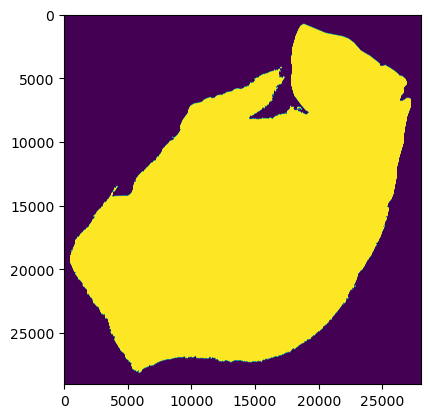

In [8]:
import pyvips
import matplotlib.pyplot as plt

img = pyvips.Image.tiffload(dir_path + "RCC-TA-142.019~B-Tissue.tif", page=2)

plt.imshow(img.numpy())
plt.show()

In [ ]:
import monai
from monai.data import WSIReader
from monai.transforms import LoadImaged, LoadImage, AsChannelFirst
from monai.data.wsi_reader import WSIReader


In [ ]:
transform = LoadImage(reader=WSIReader, backend="openslide", level=3)
image, _ = transform(images[0])
print(f"LoadImage : image shape = {image.shape}")

transformD = LoadImaged(keys=["image"], reader=WSIReader, backend="openslide", level=3)
image = transformD({"image": images[0]})["image"]
print(f"LoadImageD: image shape = {image.shape}")


In [ ]:
from cucim import CuImage
import pprint
from matplotlib import pyplot as plt
import numpy as np
import os

# import cupy as cp


def visualize(image, downsample=1):
    dpi = 80.0 * downsample
    height, width, _ = image.shape
    plt.figure(figsize=(width / dpi, height / dpi))
    plt.axis("off")
    plt.imshow(image)
    return True


plt.close("all")

pp = pprint.PrettyPrinter(indent=2, compact=True)

img = CuImage(images[0])
print("#", images[0])
metadata = img.metadata
# pp.pprint(img.metadata)#.get('cucim'))
# print(img.metadata.keys())

# print(img.associated_images)

# thumbnail_img = img.associated_image("thumbnail")
# visualize(np.asarray(thumbnail_img), 4)

import os

directory = os.fsencode(dir_path)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".svs"):
        curr_img = CuImage(directory + file)
        print(curr_img)
        print(curr_img.metadata["cucim"]["resolutions"])
        visualize(np.asarray(curr_img.read_region(level=4)), 1)


# curr_img = img.read_region(level=3)
# print(curr_img.shape)
# print(cp.asarray(curr_img))
# print(type(curr_img))
# visualize(np.asarray(curr_img), 1)

# level_count = metadata["cucim"]["resolutions"]["level_count"]
# print(level_count)
# for curr_lvl in range(1,level_count):
#     curr_img = img.read_region(level=curr_lvl)
#     done = visualize(np.asarray(curr_img), 1)


In [ ]:
#%pip install openslide-python
#!mamba install -n thesis -c conda-forge --yes openslide
from openslide import OpenSlide


### Convert ome.tiff to svs

In [ ]:
# try to convert from ome.tiff to svs
# !pip install openslide-python
import openslide

# Open the OME-TIFF file
ome_tiff = openslide.open_slide("ome_tiff_file.ome.tiff")

# Save the OME-TIFF file as an SVS file
ome_tiff.save("svs_file.svs")


### Read geojson and produce mask

In [ ]:
# 1. READ JSON ARRAY
import json

# import Geojson # pip install geojson
import matplotlib.pyplot as plt
import numpy as np
import openslide
import rasterio
import rasterio.features
from rasterio.features import geometry_mask, rasterize
from shapely.geometry import Point, Polygon
from shapely.geometry import shape
#from shapely.geometry.polygon import Polygon

base_path: str = "/home/sklein/Thesis/Scans-QuPathProjekt-RCC(1Case)-10062021/"
case: str = "RCC-TA-011.001.023~M"
image = base_path + case + ".svs"
geojson_array: str = base_path + case + ".svs.json"
geojson_feat: str = base_path + case + ".svs-FeatColl.json"

input_file = open(geojson_array)
data = json.load(input_file)

# 2. FILTER ANNOTATIONS FOR TISSUE AND TUMOR
tumor_types = [
    # "Tumor",
    "Tumor_vital",
    "diffuse tumor growth in soft tissue",
    "Angioinvasion",
    "Tumor_necrosis",
    "Tumor_regression",
]
tumor_annos = []
tissue_annos = []
for dict in data:
    props = dict["properties"]
    if props["objectType"] == "annotation":
        if props["classification"]["name"] in tumor_types:
            tumor_annos.append(dict)
        elif props["classification"]["name"] in ["Tissue"]:
            tissue_annos.append(dict)

# 3. CONVERT TO SHAPELY SHAPES
shapes = {
    annotation["properties"]["classification"]["name"]: shape(annotation["geometry"])
    for annotation in tumor_annos + tissue_annos
}

# 4. CONVERT TO MASK (TUMOR AND TISSUE)

# Open the SVS file
svs = openslide.open_slide(image)
width, height = svs.dimensions
# Create a blank mask with the same size as the SVS image
mask = np.zeros((height, width), dtype=np.uint8)

img = rasterize(shapes.values(), out_shape=(width, height))
# plt.imshow(img)
array = np.asarray(img)

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

In [ ]:
np.histogram(array, bins=2)

(array([4972622560, 4903836845]), array([0. , 0.5, 1. ]))

In [ ]:
print(f''' 
{array.shape}
{np.mean(array)}
{np.average(array)}
{np.ptp(array)}
''')

ValueError: object too deep for desired array